In [1]:
!pip install umap-learn

In [2]:
#!/usr/bin/env python3

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# For Bayesian neural network
import pymc as pm
import arviz as az

# For dimension reduction
from sklearn.manifold import TSNE
import umap

# For ML tasks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
# Create an output directory
OUTPUT_DIR = "output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Load your CSV (replace with the correct path/filename)
DATAFILE = "peas_tbl4.csv"
df = pd.read_csv(DATAFILE)

print("==== Head of the DataFrame ====")
print(df.head())
print("\n==== Summary Info ====")
print(df.info())
print("\n==== Descriptive Statistics ====")
print(df.describe())


==== Head of the DataFrame ====
           # DR7OBJID          RA        DEC  REDSHIFT  OIII_EW         L_FUV  \
0  587725073921409255  146.242618  -0.762639    0.3002    312.8      1.04       
1  588848899919446344  195.546460  -0.087897    0.2255    834.4      0.19       
2  587725576962244831  261.776373  59.817273    0.3472    651.5                 
3  587731187273892048  351.413453   0.752012    0.2770    319.6      0.99       
4  587731513693503653   50.687082   0.745111    0.3043    282.1      1.09       

       L_FUV_ERR    SFR  SFR_ERR   METALLICITY METALLICITY_ERR_UPPER  \
0      0.21       12.45     0.52      8.78                  8.85       
1      0.04        4.47     0.22      8.75                  8.87       
2                 24.98     1.48      8.71                  8.79       
3      0.06       11.11     0.85      8.70                  8.79       
4      0.27       14.22     0.80      8.83                  8.87       

  METALLICITY_ERR_LOWER  M_STELLAR  
0          

In [4]:
to_convert = ["L_FUV", "L_FUV_ERR", "METALLICITY",
              "METALLICITY_ERR_UPPER", "METALLICITY_ERR_LOWER"]
for col in to_convert:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

print("\n==== Checking NaN counts after numeric conversion ====")
print(df[to_convert].isna().sum())



==== Checking NaN counts after numeric conversion ====
L_FUV                    24
L_FUV_ERR                24
METALLICITY              14
METALLICITY_ERR_UPPER    14
METALLICITY_ERR_LOWER    14
dtype: int64


In [5]:
essential_cols = [
    "RA", "DEC", "REDSHIFT", "OIII_EW",
    "SFR", "METALLICITY", "M_STELLAR"
]
df_clean = df.dropna(subset=essential_cols).reset_index(drop=True)

print(f"Data shape after cleaning (essential only): {df_clean.shape}")

Data shape after cleaning (essential only): (66, 13)


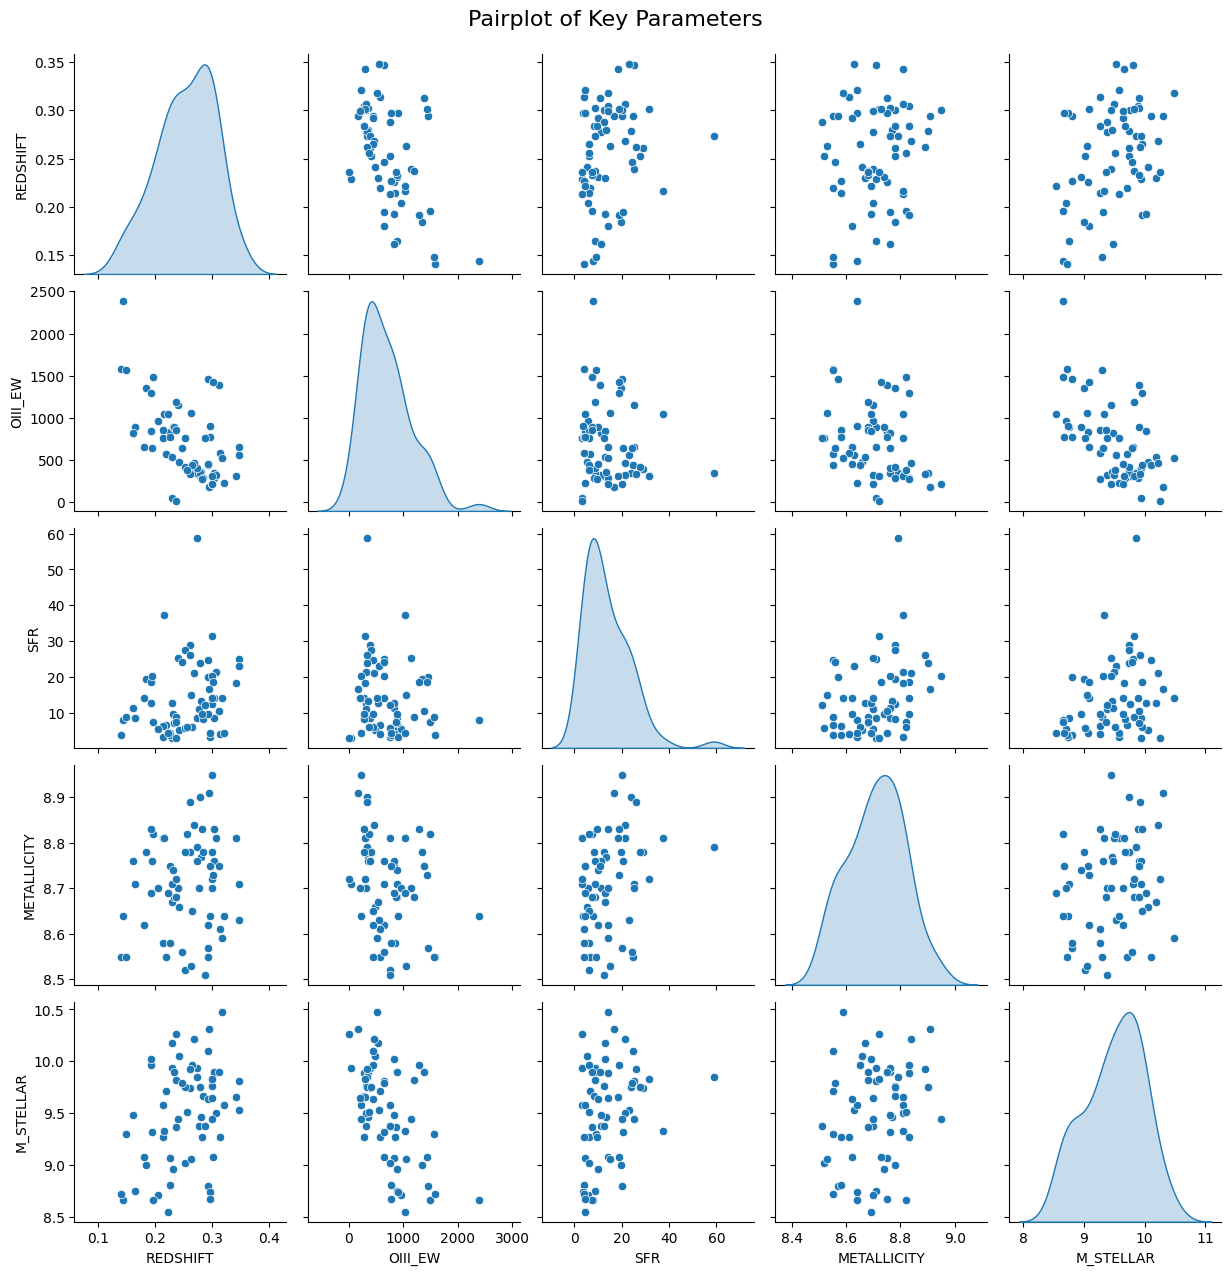

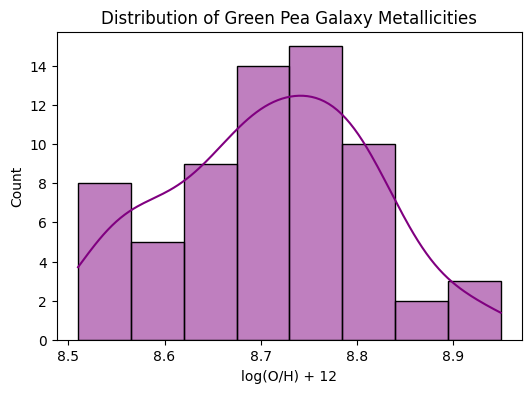

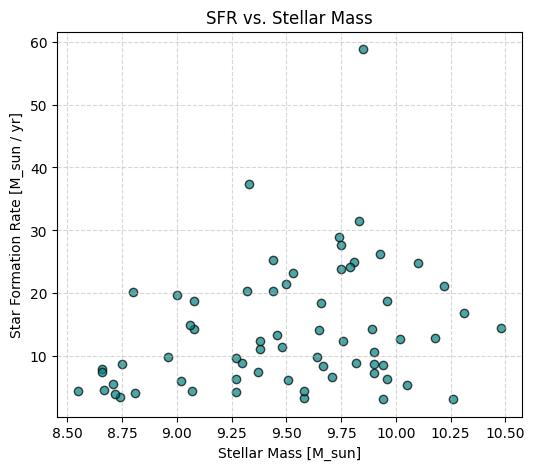

In [6]:
eda_cols = ["REDSHIFT", "OIII_EW", "SFR", "METALLICITY", "M_STELLAR"]

sns.pairplot(df_clean[eda_cols], diag_kind="kde")
plt.suptitle("Pairplot of Key Parameters", y=1.02, fontsize=16)
plt.savefig(os.path.join(OUTPUT_DIR, "pairplot_key_params.png"))
plt.show()

plt.figure(figsize=(6,4))
sns.histplot(df_clean["METALLICITY"], kde=True, color="purple")
plt.title("Distribution of Green Pea Galaxy Metallicities")
plt.xlabel("log(O/H) + 12")
plt.ylabel("Count")
plt.savefig(os.path.join(OUTPUT_DIR, "hist_metallicity.png"))
plt.show()

plt.figure(figsize=(6,5))
plt.scatter(df_clean["M_STELLAR"], df_clean["SFR"], alpha=0.7, c="teal", edgecolor="k")
plt.xlabel("Stellar Mass [M_sun]")
plt.ylabel("Star Formation Rate [M_sun / yr]")
plt.title("SFR vs. Stellar Mass")
plt.grid(True, linestyle="--", alpha=0.5)
plt.savefig(os.path.join(OUTPUT_DIR, "scatter_sfr_mass.png"))
plt.show()

In [7]:
ml_features = ["REDSHIFT", "OIII_EW", "SFR", "M_STELLAR"]
if "L_FUV" in df_clean.columns:
    ml_features.append("L_FUV")

# We also need METALLICITY as the target
ml_target = "METALLICITY"

# Next, drop rows that have missing values in *any* of these ML columns
df_ml = df_clean.dropna(subset=ml_features + [ml_target]).reset_index(drop=True)

# Now we can form X and y safely (with no NaNs)
X = df_ml[ml_features].values
y = df_ml[ml_target].values  # log(O/H)+12

print("\nShape after dropping rows with NaNs in ML columns:", X.shape)
print("Sample X:\n", X[:3])
print("Sample y:\n", y[:3])



Shape after dropping rows with NaNs in ML columns: (46, 5)
Sample X:
 [[3.002e-01 3.128e+02 1.245e+01 9.760e+00 1.040e+00]
 [2.255e-01 8.344e+02 4.470e+00 9.070e+00 1.900e-01]
 [2.770e-01 3.196e+02 1.111e+01 9.380e+00 9.900e-01]]
Sample y:
 [8.78 8.75 8.7 ]


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


 Progress                    Draws   Divergences   Step size   Grad evals   Sampling Speed   Elapsed   Remaining  
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━━━━━━━━━━━━━━━━━━━   4000    45            0.00        1023         4.11 draws/s     0:16:13   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━   4000    129           0.00        1023         4.18 draws/s     0:15:55   0:00:00

ERROR:pymc.stats.convergence:There were 174 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details



BNN Posterior Summary:
           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
W1[0, 0] -0.041  0.672  -1.477    1.225      0.022    0.021     865.0   
W1[0, 1] -0.010  0.681  -1.401    1.335      0.029    0.027     546.0   
W1[0, 2] -0.016  0.617  -1.361    1.070      0.019    0.026    1026.0   
W1[0, 3] -0.051  0.735  -1.512    1.388      0.027    0.024     740.0   
W1[0, 4] -0.001  0.693  -1.372    1.341      0.028    0.025     537.0   
W1[1, 0]  0.052  0.924  -1.827    1.868      0.044    0.033     466.0   
W1[1, 1] -0.071  0.855  -1.905    1.572      0.047    0.039     351.0   
W1[1, 2]  0.016  0.832  -1.575    1.837      0.038    0.059     525.0   
W1[1, 3] -0.038  0.973  -1.898    1.984      0.051    0.046     378.0   
W1[1, 4] -0.087  0.905  -1.862    1.787      0.054    0.046     305.0   
W1[2, 0]  0.011  0.734  -1.393    1.555      0.029    0.031     677.0   
W1[2, 1] -0.004  0.704  -1.379    1.477      0.038    0.035     360.0   
W1[2, 2]  0.019  0.671  -1.

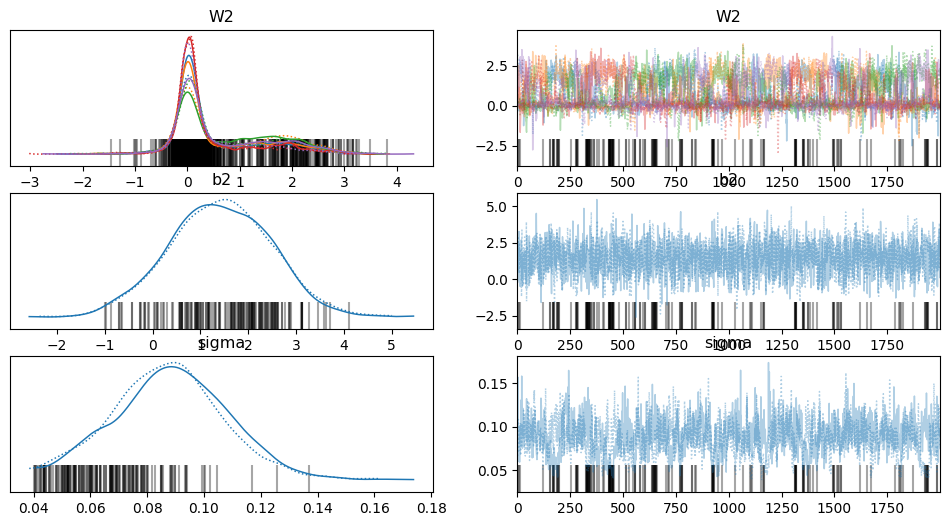

In [9]:
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import os

# Ensure that X_train_scaled and y_train are defined
# Example: X_train_scaled = ... (your scaled features)
#          y_train = ... (your target variable)

n_features = X_train_scaled.shape[1]
n_hidden = 5

# Define the output directory
OUTPUT_DIR = "output"  # Change this to your desired output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)  # Create the directory if it doesn't exist

with pm.Model() as model_bnn:
    # pm.Data containers
    X_data = pm.Data("X_data", X_train_scaled)
    Y_data = pm.Data("Y_data", y_train)

    # Priors for the hidden layer
    W1 = pm.Normal("W1", mu=0.0, sigma=1.0, shape=(n_features, n_hidden))
    b1 = pm.Normal("b1", mu=0.0, sigma=1.0, shape=(n_hidden,))

    # Priors for the output layer
    W2 = pm.Normal("W2", mu=0.0, sigma=1.0, shape=(n_hidden,))  # Correct shape
    b2 = pm.Normal("b2", mu=0.0, sigma=1.0)

    # Forward pass
    def neural_network(x_):
        h_lin = pm.math.dot(x_, W1) + b1
        h_act = pm.math.maximum(h_lin, 0)  # ReLU activation
        out = pm.math.dot(h_act, W2) + b2
        return out

    # Prior for the noise
    sigma = pm.HalfNormal("sigma", sigma=1.0)

    # Expected value of the output
    mu = neural_network(X_data)

    # Likelihood of the observed data
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y_data)

    # More robust initialization to avoid bad starting points
    trace_bnn = pm.sample(
        draws=2000,
        tune=2000,
        target_accept=0.9,
        random_seed=42,
        chains=2,  # Increased number of chains for better exploration
        cores=2,   # Use multiple cores if available
        init="jitter+adapt_diag"
    )

# Summary of the posterior
summary_bnn = az.summary(trace_bnn, var_names=["W1", "b1", "W2", "b2", "sigma"])
print("\nBNN Posterior Summary:")
print(summary_bnn)

# Trace plot for a quick diagnostic
az.plot_trace(trace_bnn, var_names=["W2", "b2", "sigma"])
plt.savefig(os.path.join(OUTPUT_DIR, "bnn_trace.png"))
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


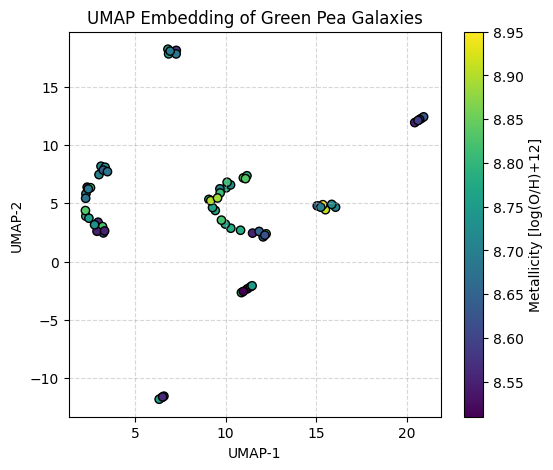

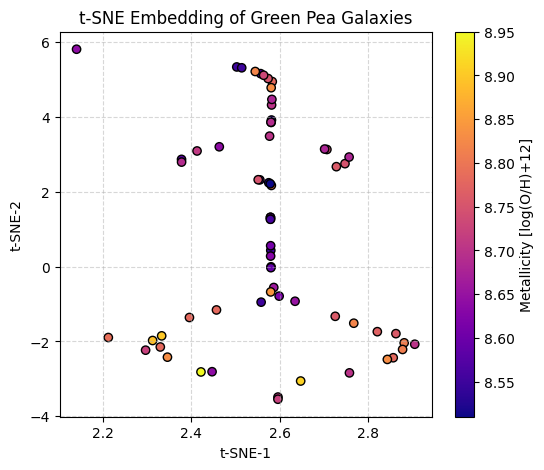

In [ ]:
dr_cols = ["REDSHIFT", "OIII_EW", "SFR", "METALLICITY", "M_STELLAR"]
df_dr = df_clean[dr_cols].dropna().reset_index(drop=True)
X_dr = df_dr.values

# UMAP
reducer = umap.UMAP(n_neighbors=5, min_dist=0.3, n_components=2, random_state=42)
X_umap = reducer.fit_transform(X_dr)

plt.figure(figsize=(6,5))
sc_umap = plt.scatter(X_umap[:,0], X_umap[:,1],
                      c=df_dr["METALLICITY"], cmap="viridis", edgecolor="k")
plt.colorbar(sc_umap, label="Metallicity [log(O/H)+12]")
plt.title("UMAP Embedding of Green Pea Galaxies")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.grid(linestyle="--", alpha=0.5)
plt.savefig(os.path.join(OUTPUT_DIR, "umap_embedding.png"))
plt.show()

# t-SNE
tsne_model = TSNE(n_components=2, perplexity=30,
                  learning_rate="auto", init="pca", random_state=42)
X_tsne = tsne_model.fit_transform(X_dr)

plt.figure(figsize=(6,5))
sc_tsne = plt.scatter(X_tsne[:,0], X_tsne[:,1],
                      c=df_dr["METALLICITY"], cmap="plasma", edgecolor="k")
plt.colorbar(sc_tsne, label="Metallicity [log(O/H)+12]")
plt.title("t-SNE Embedding of Green Pea Galaxies")
plt.xlabel("t-SNE-1")
plt.ylabel("t-SNE-2")
plt.grid(linestyle="--", alpha=0.5)
plt.savefig(os.path.join(OUTPUT_DIR, "tsne_embedding.png"))
plt.show()

In [ ]:
results_table = pd.DataFrame({
    "True_Metallicity": y_test,
    "Predicted_Metallicity": y_pred_test_mean
})
results_table.to_csv(os.path.join(OUTPUT_DIR, "test_predictions_table.csv"), index=False)
print("\n==== Test Predictions Table (first 5 rows) ====")
print(results_table.head(5))

posterior_table = summary_bnn.reset_index()
posterior_table.columns = ["Parameter", "mean", "sd", "hdi_3%", "hdi_97%",
                           "mcse_mean", "mcse_sd","ess_bulk", "ess_tail", "r_hat"]
posterior_table.to_csv(os.path.join(OUTPUT_DIR, "posterior_summary_table.csv"), index=False)
print("\n==== Posterior Summary Table (first 5 rows) ====")
print(posterior_table.head(5))

print(f"\nAll plots and tables have been saved in the '{OUTPUT_DIR}' folder.")


==== Test Predictions Table (first 5 rows) ====
   True_Metallicity  Predicted_Metallicity
0              8.89               8.804911
1              8.72               8.808581
2              8.84               8.743891
3              8.73               8.623102
4              8.56               8.734680

==== Posterior Summary Table (first 5 rows) ====
  Parameter   mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
0  W1[0, 0] -0.011  0.650  -1.370    1.172      0.024    0.017     744.0   
1  W1[0, 1] -0.042  0.590  -1.285    1.081      0.024    0.017     599.0   
2  W1[0, 2] -0.003  0.708  -1.373    1.451      0.030    0.021     536.0   
3  W1[0, 3] -0.064  0.685  -1.342    1.351      0.041    0.029     269.0   
4  W1[0, 4] -0.009  0.686  -1.434    1.290      0.031    0.022     449.0   

   ess_tail  r_hat  
0     953.0   1.00  
1     863.0   1.01  
2    1130.0   1.01  
3     498.0   1.01  
4     974.0   1.01  

All plots and tables have been saved in the 'output' folder

Bayesian Hierarchical Framework

Output()

ERROR:pymc.stats.convergence:There were 80 divergences after tuning. Increase `target_accept` or reparameterize.


                   mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta              6.440  7.416  -6.640   20.765      0.292    0.221     644.0   
group_effects[0]  4.032  7.574 -10.579   17.275      0.295    0.212     658.0   
group_effects[1]  4.879  7.608  -9.511   18.866      0.295    0.211     665.0   
group_effects[2]  9.905  7.599  -4.511   24.243      0.297    0.210     656.0   
group_effects[3]  6.818  7.519  -7.497   20.612      0.292    0.206     663.0   
group_effects[4]  6.964  7.536  -6.670   21.408      0.293    0.207     664.0   
mu_sfr            6.348  7.394  -7.379   19.928      0.286    0.202     666.0   
sigma             7.199  0.386   6.473    7.894      0.011    0.008    1241.0   
sigma_sfr         3.700  2.142   0.684    7.517      0.069    0.049     439.0   

                  ess_tail  r_hat  
beta                 775.0   1.00  
group_effects[0]     813.0   1.00  
group_effects[1]     877.0   1.00  
group_effects[2]     594.0   1.01  
group_eff

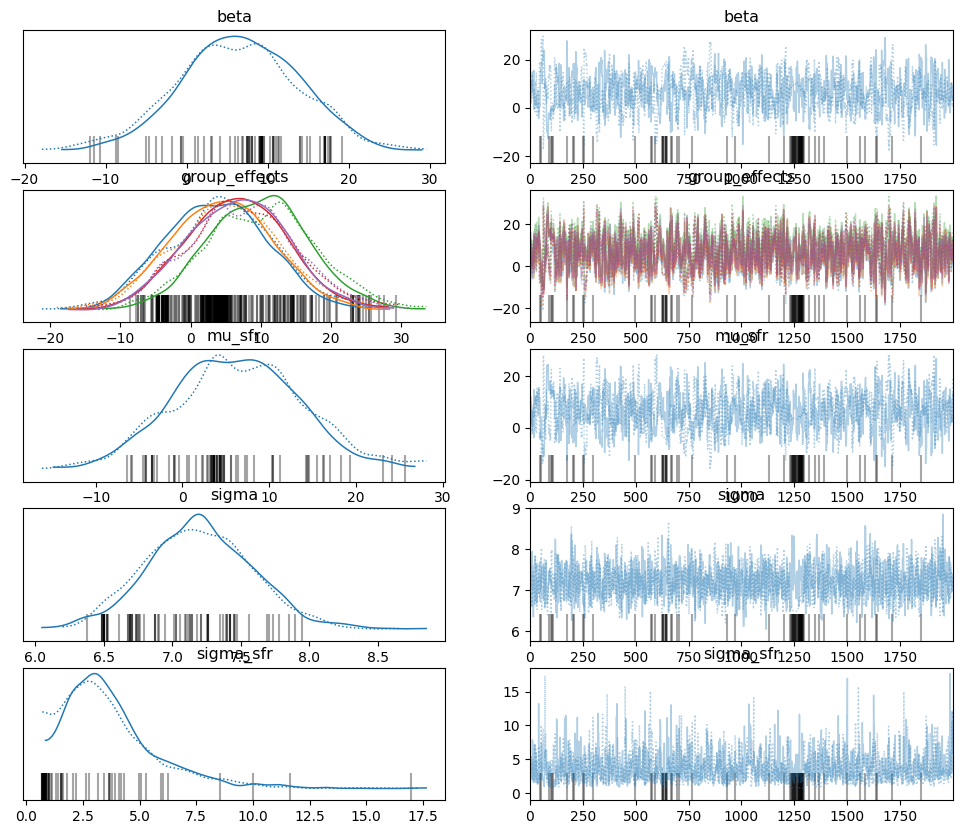

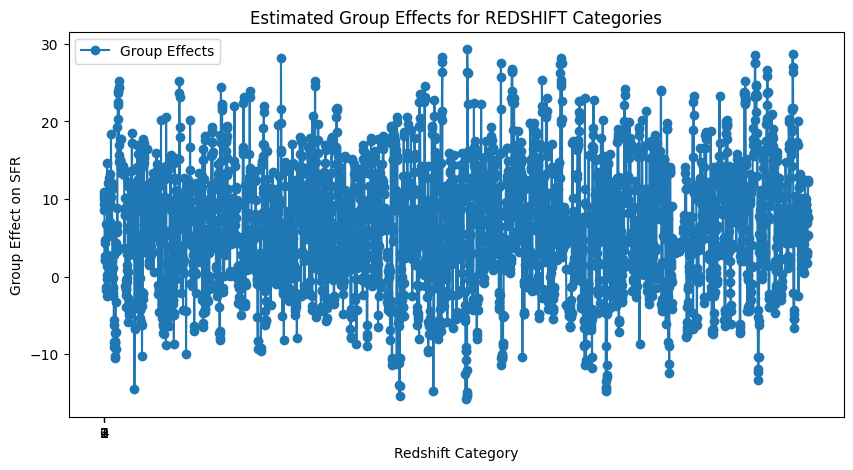

In [ ]:


# Clean the data: Drop rows with missing values in SFR and REDSHIFT
data = df.dropna(subset=['SFR', 'REDSHIFT'])

# Create a categorical variable for REDSHIFT
data['REDSHIFT_CAT'] = pd.qcut(data['REDSHIFT'], q=5, labels=False)  # Create 5 quantiles

# Define the model
with pm.Model() as hierarchical_model:
    # Hyperpriors for group-level effects
    mu_sfr = pm.Normal('mu_sfr', mu=0, sigma=10)
    sigma_sfr = pm.HalfNormal('sigma_sfr', sigma=10)

    # Group-level effects for each redshift category
    group_effects = pm.Normal('group_effects', mu=mu_sfr, sigma=sigma_sfr, shape=len(data['REDSHIFT_CAT'].unique()))

    # Priors for the overall intercept and slope
    beta = pm.Normal('beta', mu=0, sigma=10)

    # Likelihood
    mu = beta + group_effects[data['REDSHIFT_CAT'].values]  # Use group effects based on category
    sigma = pm.HalfNormal('sigma', sigma=1)
    likelihood = pm.Normal('likelihood', mu=mu, sigma=sigma, observed=data['SFR'])

    # Perform MCMC sampling
    trace = pm.sample(2000, tune=1000, target_accept=0.9)

# Summarize posterior distribution
summary = az.summary(trace)
print(summary)

# Plot the trace
az.plot_trace(trace)
plt.show()

# Plot the group effects
plt.figure(figsize=(10, 5))
# Accessing the group effects from the trace, for each category.
group_effects_trace = trace.posterior["group_effects"].stack(samples=("chain", "draw"))

# Calculate the mean group effects for each category across all samples.
mean_group_effects = group_effects_trace.mean(axis=0).values

# Plot the mean group effects.
plt.plot(mean_group_effects, marker='o', label='Group Effects')

#plt.plot(trace['group_effects'].mean(axis=0), marker='o', label='Group Effects')
plt.title('Estimated Group Effects for REDSHIFT Categories')
plt.xlabel('Redshift Category')
plt.ylabel('Group Effect on SFR')
plt.xticks(ticks=np.arange(len(data['REDSHIFT_CAT'].unique())), labels=np.arange(len(data['REDSHIFT_CAT'].unique())))
plt.legend()
plt.show()

Deep Neural Network Surrogate for Non-Linear Emission-
Line Scaling

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 217ms/step - loss: 258.9090 - val_loss: 177.8821
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 281.5212 - val_loss: 176.6671
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 278.9872 - val_loss: 175.5574
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 300.2204 - val_loss: 174.4647
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 299.5732 - val_loss: 173.4014
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 261.8742 - val_loss: 172.3503
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 299.8232 - val_loss: 171.3053
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 269.2328 - val_loss: 170.2720
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 310.1724 - val_loss: 169.2446
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 299.7046 - val_loss: 168.1931
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 266.8258 - val_loss: 167.0862
Epoch 12/100
2/2 ━━━━━━━━━━━━

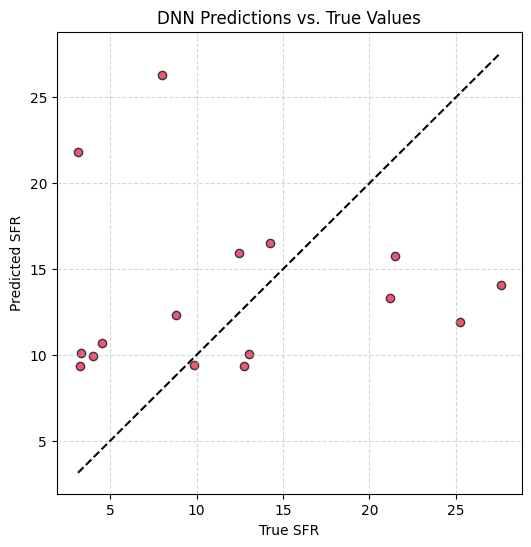

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt


# Clean the data: Drop rows with missing values in relevant columns
data = df.dropna(subset=['OIII_EW', 'SFR'])  # Example: using OIII_EW as input and SFR as output

# Define features and target variable
X = data[['OIII_EW']]  # Input features (you can add more features as needed)
y = data['SFR']  # Target variable

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the DNN model
model = keras.Sequential([
    layers.Input(shape=(X_train_scaled.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2)

# Evaluate the model
loss = model.evaluate(X_test_scaled, y_test)
print(f'Test Loss (MSE): {loss:.4f}')

# Make predictions
y_pred = model.predict(X_test_scaled)

# Plot predictions vs actual values
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color="crimson", edgecolor="k")
xmin, xmax = min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())
plt.plot([xmin, xmax], [xmin, xmax], "k--")
plt.xlabel("True SFR")
plt.ylabel("Predicted SFR")
plt.title("DNN Predictions vs. True Values")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

Inference and Training Objective

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 476ms/step - loss: 271.2094 - val_loss: 175.1181
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 293.4132 - val_loss: 173.7415
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 265.5771 - val_loss: 172.3876
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - loss: 309.2317 - val_loss: 171.0473
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 266.0511 - val_loss: 169.7509
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 260.4483 - val_loss: 168.4647
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - loss: 270.2131 - val_loss: 167.1476
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - loss: 289.3715 - val_loss: 165.8132
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 269.9682 - val_loss: 164.4047
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 239.4820 - val_loss: 162.9278
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 285.3719 - val_loss: 161.3596
Epoch 12/100
2/2 ━━

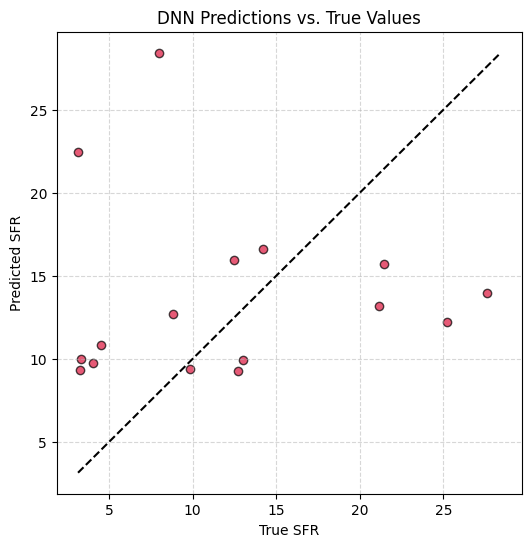

In [12]:


# Clean the data: Drop rows with missing values in relevant columns
data = df.dropna(subset=['OIII_EW', 'SFR'])  # Example: using OIII_EW as input and SFR as output

# Define features and target variable
X = data[['OIII_EW']]  # Input features (you can add more features as needed)
y = data['SFR']  # Target variable

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the DNN model
model = keras.Sequential([
    layers.Input(shape=(X_train_scaled.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)  # Output layer for regression
])

# Compile the model with a training objective
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2)

# Evaluate the model
loss = model.evaluate(X_test_scaled, y_test)
print(f'Test Loss (MSE): {loss:.4f}')

# Inference: Make predictions on the test set
y_pred = model.predict(X_test_scaled)

# Plot predictions vs actual values
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color="crimson", edgecolor="k")
xmin, xmax = min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())
plt.plot([xmin, xmax], [xmin, xmax], "k--")
plt.xlabel("True SFR")
plt.ylabel("Predicted SFR")
plt.title("DNN Predictions vs. True Values")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

Non-linear Dimensionality Reduction for Exploratory Analysis

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


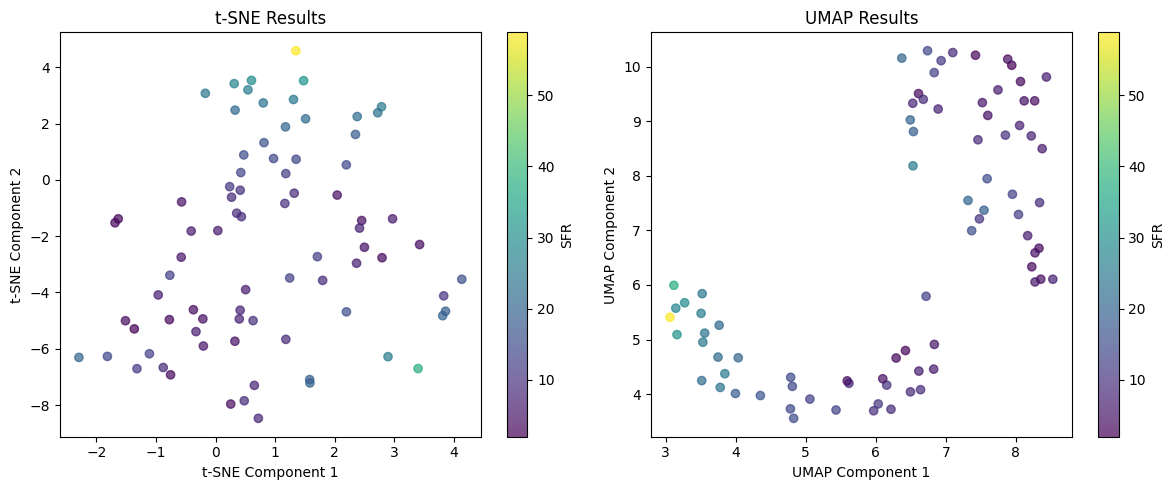

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import umap

# Clean the data: Drop rows with missing values in relevant columns
data = df.dropna(subset=['OIII_EW', 'SFR', 'REDSHIFT'])  # Example: using OIII_EW, SFR, and REDSHIFT

# Select features for dimensionality reduction
features = data[['OIII_EW', 'SFR', 'REDSHIFT']]  # You can add more features as needed

# Scale the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Non-linear Dimensionality Reduction using t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(features_scaled)

# Non-linear Dimensionality Reduction using UMAP
umap_model = umap.UMAP(n_components=2, random_state=42)
umap_results = umap_model.fit_transform(features_scaled)

# Visualization of t-SNE results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=data['SFR'], cmap='viridis', alpha=0.7)
plt.colorbar(label='SFR')
plt.title('t-SNE Results')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

# Visualization of UMAP results
plt.subplot(1, 2, 2)
plt.scatter(umap_results[:, 0], umap_results[:, 1], c=data['SFR'], cmap='viridis', alpha=0.7)
plt.colorbar(label='SFR')
plt.title('UMAP Results')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')

plt.tight_layout()
plt.show()